# Area weights factor computation

In [1]:
%run review/__common.py
%load_ext autoreload
%autoreload 2

[W1130 16:40:36.892607683 Utils.hpp:135] Warning: Environment variable NCCL_ASYNC_ERROR_HANDLING is deprecated; use TORCH_NCCL_ASYNC_ERROR_HANDLING instead (function operator())



Right after `datapipe`, `area` is initialized [1]. What is it and what for?

```python
class GraphCastTrainer(BaseTrainer):
    def __init__(self, cfg: DictConfig, dist, rank_zero_logger):
        ...
        # get normalized area
        self.area = normalized_grid_cell_area(self.lat_lon_grid[:, :, 0], unit="deg")
```

This requires `lat_lon_grid` which I dig out of the GraphCast Model [2]:

```python
class GraphCastNet(Module):
    ...
    def __init__(...):
        ...
        # create the lat_lon_grid
        self.latitudes = torch.linspace(-90, 90, steps=input_res[0]) # from init we have that input_res[0] is 721
        self.longitudes = torch.linspace(-180, 180, steps=input_res[1] + 1)[1:] # from init we have that input_res[1] is 1440
        self.lat_lon_grid = torch.stack(
            torch.meshgrid(self.latitudes, self.longitudes, indexing="ij"), dim=-1
        )
```

- [1] https://vscode.dev/github/NVIDIA/modulus/blob/main/examples/weather/graphcast/train_graphcast.py#L218
- [2] https://vscode.dev/github/NVIDIA/modulus/blob/main/modulus/models/graphcast/graph_cast_net.py#L297

In [3]:
input_res = (721, 1440)
latitudes = torch.linspace(-90, 90, steps=input_res[0])
longitudes = torch.linspace(-180, 180, steps=input_res[1] + 1)[1:]

lat_lon_grid = torch.stack(torch.meshgrid(latitudes, longitudes, indexing="ij"), dim=-1)
lat_lon_grid.shape, lat_lon_grid[0, 0], lat_lon_grid[input_res[0]//2, input_res[1]//2-1]

(torch.Size([721, 1440, 2]), tensor([ -90.0000, -179.7500]), tensor([0., 0.]))

So, `lat_lon_grid` is actually a mapper between 0-indexed coordinates over the `721, 1440` rectangle of the input channels, and the latitudes and longituted coordinates of such points.

The `+ 1)[1:]` trick ensures that the -180 and +180 degrees on the longitutes (which are actually the exact same point) do not get counted twice.

---

So, back to the `normalized_grid_cell_area` function:

```python
# get normalized area
self.area = normalized_grid_cell_area(self.lat_lon_grid[:, :, 0], unit="deg")
```

`lat_lon_grid[:, :, 0]` selects all the latitudes (poles to poles) coordinates.

The function definition is found in [1]:

```python
from modulus.utils.graphcast.graph_utils import deg2rad

# Included from another file
def deg2rad(deg: Tensor) -> Tensor:
    """Converts degrees to radians"""
    return deg * np.pi / 180

def normalized_grid_cell_area(lat: Tensor, unit="deg") -> Tensor:
    """Normalized area of the latitude-longitude grid cell"""
    if unit == "deg":
        lat = deg2rad(lat)
    area = torch.abs(torch.cos(lat))
    return area / torch.mean(area)
```

- [1] https://vscode.dev/github.com/NVIDIA/modulus/blob/main/examples/weather/graphcast/loss/utils.py#L23

In [4]:
from loss.utils import normalized_grid_cell_area

lat_lon_grid[:, :4, 0]

tensor([[-90.0000, -90.0000, -90.0000, -90.0000],
        [-89.7500, -89.7500, -89.7500, -89.7500],
        [-89.5000, -89.5000, -89.5000, -89.5000],
        ...,
        [ 89.5000,  89.5000,  89.5000,  89.5000],
        [ 89.7500,  89.7500,  89.7500,  89.7500],
        [ 90.0000,  90.0000,  90.0000,  90.0000]])

In [5]:
def deg2rad(deg):
    return deg * np.pi / 180

deg2rad(lat_lon_grid[:, :4, 0])

tensor([[-1.5708, -1.5708, -1.5708, -1.5708],
        [-1.5664, -1.5664, -1.5664, -1.5664],
        [-1.5621, -1.5621, -1.5621, -1.5621],
        ...,
        [ 1.5621,  1.5621,  1.5621,  1.5621],
        [ 1.5664,  1.5664,  1.5664,  1.5664],
        [ 1.5708,  1.5708,  1.5708,  1.5708]])

In [6]:
torch.cos(deg2rad(lat_lon_grid[:, :4, 0]))

tensor([[-4.3711e-08, -4.3711e-08, -4.3711e-08, -4.3711e-08],
        [ 4.3632e-03,  4.3632e-03,  4.3632e-03,  4.3632e-03],
        [ 8.7266e-03,  8.7266e-03,  8.7266e-03,  8.7266e-03],
        ...,
        [ 8.7266e-03,  8.7266e-03,  8.7266e-03,  8.7266e-03],
        [ 4.3632e-03,  4.3632e-03,  4.3632e-03,  4.3632e-03],
        [-4.3711e-08, -4.3711e-08, -4.3711e-08, -4.3711e-08]])

In [7]:
area = normalized_grid_cell_area(lat_lon_grid[:, :, 0], unit="deg")
area[:, :4]

tensor([[6.8757e-08, 6.8757e-08, 6.8757e-08, 6.8757e-08],
        [6.8633e-03, 6.8633e-03, 6.8633e-03, 6.8633e-03],
        [1.3727e-02, 1.3727e-02, 1.3727e-02, 1.3727e-02],
        ...,
        [1.3727e-02, 1.3727e-02, 1.3727e-02, 1.3727e-02],
        [6.8633e-03, 6.8633e-03, 6.8633e-03, 6.8633e-03],
        [6.8757e-08, 6.8757e-08, 6.8757e-08, 6.8757e-08]])

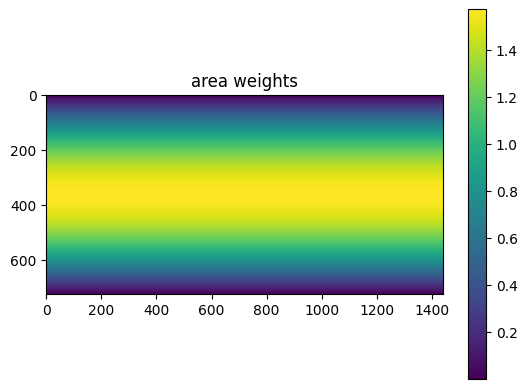

In [8]:
plt.imshow(area)
plt.colorbar()
plt.title("area weights")
plt.show()

The `normalized_grid_cell_area` function seems to compute a weighing factor for the gridpoints to account for the density of points at different latitudes.